# Задача №1 - Лабиринт

Реализуйте алгоритм поиска выхода из лабиринта по растровому изобажению. Вам нужно написать код, который будет находить путь (координаты пикселей) от заданного входа сверху до выхода снизу.

Отрисуйте получившийся маршрут на карте с помощью функции `plot_maze_path(img, coords)` или воспользуйтесь вам известным графическим инструментом.

In [1]:
# импорт модулей
import cv2
import sys

import matplotlib.pyplot as plt
import numpy as np

## Функция для отрисовки изображения

Используем заранее написанную функцию `plot_one_image` для отображения картинок (модифицировав её так, чтобы она отрисовывала картинку в два раза меньше и не жёлто-фиолетовой).

In [2]:
def plot_one_image(image: np.ndarray, title: str) -> None:
    """
    Отобразить изображение с помощью matplotlib.
    Вспомогательная функция
    
    :param image: изображение для отображения
    :return: None
    """
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    
    plt.title(title)
    
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    plt.show()

## Решение

Начнём поиск пути с загрузки первой картинки - лабиринта 20 на 20 - и сразу преобразуем её в градации серого для более удобной работы. Выведем картинку на экран.

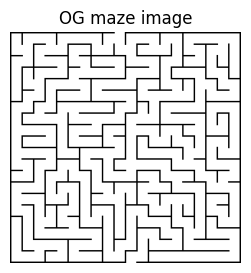

In [3]:
path = r'images//20 by 20 orthogonal maze.png'

img = cv2.imread(cv2.samples.findFile(path))

if img is None:
    sys.exit("Could not read the image.")

img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plot_one_image(image=img, title="OG maze image")

Преобразуем загруженное изображение в чёрно-белое и инвертируем его с помощью thresholding (установление порога).

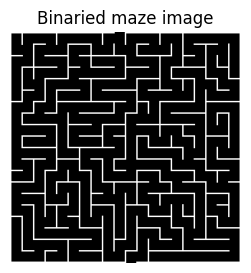

In [4]:
ret, binary_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV)

plot_one_image(image=binary_img, title="Binaried maze image")

Найдём контуры лабиринта. 

Сам лабиринт состоит из двух фигур, разделённых между собой путём от входа в лабиринт до выхода из него. Таким образом, внешние контуры этих фигур образуют искомый путь (при этом также вбирая в себя все тупики).

Далее создадим новую картинку для отображения решения лабиринта - `solution` - и выведем на ней найденные контуры.

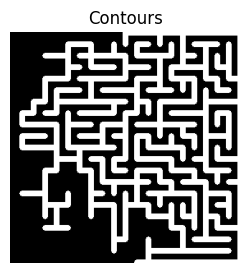

In [5]:
contours, hierarchy = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

solution = np.zeros(binary_img.shape, np.uint8)

cv2.drawContours(solution, contours, 0, (255, 255, 255), 5)

plot_one_image(image=solution, title="Contours")

Для уточнения решения, грубо отрисованного с помощью контуров, применим к картинке `solution` две операции - дилатация и эрозия. Начнём с первой.

Дилатация расширяет белые области (путь). Это заполняет пробелы и делает путь более толстым, фактически "сглаживая" его.

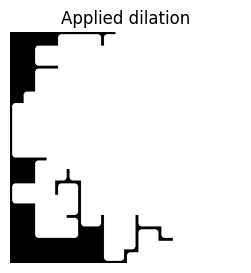

In [6]:
kernel = np.ones((21, 21), np.uint8)

dilated = cv2.dilate(solution, kernel, iterations=1)

plot_one_image(image=dilated, title="Applied dilation")

Эрозия сужает белые области (путь). Это уменьшает толщину пути, но сохраняет его основную форму.

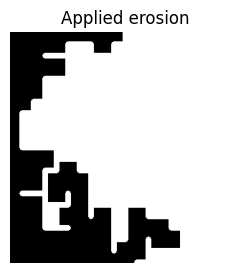

In [7]:
erosion = cv2.erode(dilated, kernel, iterations=1)

plot_one_image(image=erosion, title="Applied erosion")

Разница между дилатацией и эрозией и будет означать искомое решение. Когда мы вычитаем результат эрозии из результата дилатации, мы находим области, которые были расширены дилатацией, но утеряны во время эрозии. Эти области находятся на границах "расширенного" (т.е. включающего в себя тупики) пути, и образуют достаточно тонкую линию, которая приблизительно следует за центральной линией оригинального, более толстого пути.

In [8]:
diff = cv2.absdiff(erosion, dilated)

img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

img[diff == 255] = (0, 255, 0)

Выведем получившиеся решение, наложив его на оригинальную картинку.

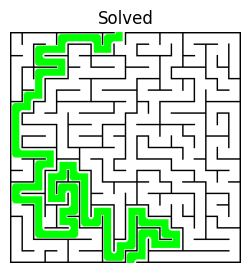

In [9]:
plot_one_image(image=img, title="Solved")

## Найденные пути через лабиринт

Оформим весь вышенаписанный код в виде функции, чтобы применить его к оставшимся лабиринтам.

In [10]:
def find_maze_path(path_to_image: str):
    """
    Найти путь через лабиринт с помощью операций дилатации и эрозии

    :param path_to_image: путь к картинке с лабиринтом
    :return:
    """
    
    img = cv2.imread(cv2.samples.findFile(path_to_image))

    if img is None:
        sys.exit("Could not read the image.")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, binary_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV)

    contours, hierarchy = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    solution = np.zeros(binary_img.shape, np.uint8)
    cv2.drawContours(solution, contours, 0, (255, 255, 255), 5)

    kernel = np.ones((21, 21), np.uint8)
    dilated = cv2.dilate(solution, kernel, iterations=1)

    erosion = cv2.erode(dilated, kernel, iterations=1)

    diff = cv2.absdiff(erosion, dilated)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img[diff == 255] = (0, 255, 0)

    plot_one_image(image=img, title="Solved")

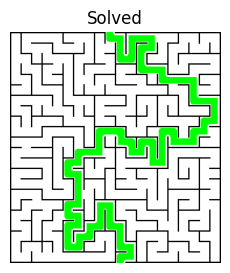

In [11]:
path = r'images//20 by 22 orthogonal maze.png'
find_maze_path(path_to_image=path)

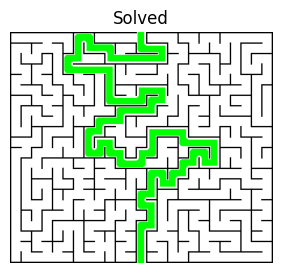

In [12]:
path = r'images//25 by 22 orthogonal maze.png'
find_maze_path(path_to_image=path)

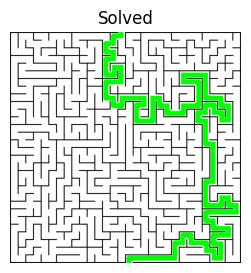

In [13]:
path = r'images//30 by 30 orthogonal maze.png'
find_maze_path(path_to_image=path)

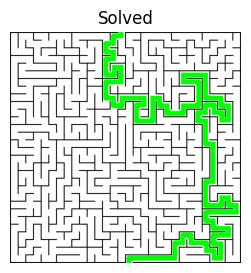

In [14]:
path = r'images//30 by 30 orthogonal maze.png'
find_maze_path(path_to_image=path)